In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import pickle                


In [2]:
from pyensembl import EnsemblRelease

ensembl = EnsemblRelease(85)

In [3]:
from itertools import combinations
from scipy.stats import fisher_exact
from statsmodels.sandbox.stats.multicomp import multipletests

path = '../../R_script/WGCNA/'
res = []

for t in os.listdir(path):
    dfm = pd.read_csv(path + '%s/gene_module.csv' % t, header = None)
    
    common_genes = set(dfm[0])
    ## get order for genes to avoid double count edges
    g2ord = {g:i for i, g in enumerate(sorted(common_genes))}    
    
    ## get module genes
    mod2genes = {}
    for g, m in zip(dfm[0], dfm[1]):
        if g not in common_genes:
            continue
        if m == 'grey':
            continue

        if m not in mod2genes:
            mod2genes[m] = set()
        mod2genes[m].add(g)

    ## get wgcna edges between common genes
    elist_wgcna = set()
    for m, gs in mod2genes.items():
        for g1, g2 in combinations(gs, r = 2):
            if g1 != g2:
                if g2ord[g1] < g2ord[g2]:
                    elist_wgcna.add((g1, g2))
                else:
                    elist_wgcna.add((g2, g1))
                    
    gene2contig = {}
    for g in common_genes:
        try:
            contig = ensembl.gene_by_id(g).contig
            gene2contig[g] = contig
        except:
            pass
        
        
    res_freq = []
    for m in mod2genes:
        n1 = Counter([gene2contig[g] for g in mod2genes[m] if g in gene2contig]).most_common(1)[0][1]
        n2 = len(mod2genes[m])
        res_freq.append(float(n1) / float(n2))
    res.append(res_freq)

In [4]:
Counter([gene2contig[g] for g in mod2genes[m] if g in gene2contig])

Counter({'1': 1,
         '11': 2,
         '12': 1,
         '14': 2,
         '15': 1,
         '16': 2,
         '17': 2,
         '18': 1,
         '19': 13,
         '2': 2,
         '3': 2,
         '4': 1,
         '5': 2,
         '7': 6,
         '8': 1,
         '9': 1})

In [5]:
n1, n2

(13, 41)

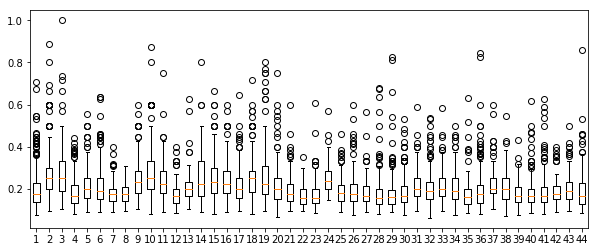

In [6]:
import matplotlib.pyplot as plt
% matplotlib inline
fig = plt.figure(figsize = (10, 4))
plt.boxplot(res)
plt.show()

In [7]:
from scipy.stats import chisquare
from itertools import combinations
from scipy.stats import fisher_exact
from statsmodels.sandbox.stats.multicomp import multipletests

res = []

for t in os.listdir(path):
    dfm = pd.read_csv(path + '%s/gene_module.csv' % t, header = None)
    
    common_genes = set(dfm[0])
    
    ## get module genes
    mod2genes = {}
    for g, m in zip(dfm[0], dfm[1]):
        if m == 'grey':
            continue

        if m not in mod2genes:
            mod2genes[m] = set()
        
        mod2genes[m].add(g)
        
    gene2contig = {}
    for g in common_genes:
        try:
            contig = ensembl.gene_by_id(g).contig
            gene2contig[g] = contig 
            
        except:
            pass
                       
        
    tmp = Counter([gene2contig[g] for g in common_genes if g in gene2contig])
    id2contig = tmp.keys()
    freq = np.array([float(tmp[c]) for c in id2contig])
    freq = freq / freq.sum()
    
    pvals = []
    for m in mod2genes:
        tmp = Counter([gene2contig[g] for g in mod2genes[m] if g in gene2contig])
        c0 = np.array([float(tmp[c]) for c in id2contig])
        chi, pval = chisquare(c0, freq * c0.sum())
        pvals.append(pval)
        #print c0, pval

In [8]:
from scipy.stats import chisquare
from itertools import combinations
from scipy.stats import fisher_exact
from statsmodels.sandbox.stats.multicomp import multipletests

res = []

for t in os.listdir(path):
    dfm = pd.read_csv(path + '%s/gene_module.csv' % t, header = None)
    
    common_genes = set(dfm[0])
    
    ## get module genes
    mod2genes = {}
    for g, m in zip(dfm[0], dfm[1]):
        if m == 'grey':
            continue

        if m not in mod2genes:
            mod2genes[m] = set()
        
        mod2genes[m].add(g)
        
    gene2contig = {}
    for g in common_genes:
        try:
            contig = ensembl.gene_by_id(g).contig
            gene2contig[g] = contig 
            
        except:
            pass
                       
        
    tmp = Counter([gene2contig[g] for g in common_genes if g in gene2contig])
    id2contig = tmp.keys()
    freq = np.array([float(tmp[c]) for c in id2contig])
    freq = freq / freq.sum()
    
    pvals = []
    for m in mod2genes:
        tmp = Counter([gene2contig[g] for g in mod2genes[m] if g in gene2contig])
        c0 = np.array([float(tmp[c]) for c in id2contig])
        chi, pval = chisquare(c0, freq * c0.sum())
        pvals.append(pval)
        
    _, adjp, _, _ = multipletests(pvals)
    res.append((t, np.sum(adjp < 0.05), len(mod2genes)))
    

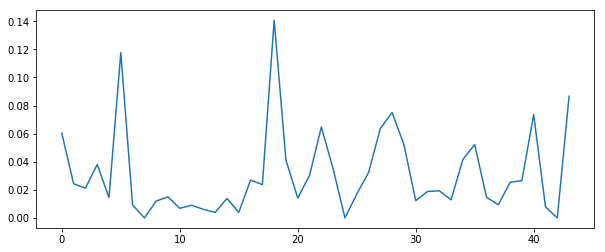

In [9]:
import matplotlib.pyplot as plt
% matplotlib inline
fig = plt.figure(figsize = (10, 4))
plt.plot([float(item[1]) / float(item[2]) for item in res])
plt.show()

In [10]:
from itertools import combinations
from scipy.stats import fisher_exact

path = '../../R_script/WGCNA/'
res = []

for t in os.listdir(path):
    dfm = pd.read_csv(path + '%s/gene_module.csv' % t, header = None)
    
    
    ## common genes in wgcna & multiple-species network
    common_genes = set(dfm[0])
    
    contig2genes = {}
    contig_genes = set()
    for g in common_genes:
        try:
            contig = ensembl.gene_by_id(g).contig
            
            if contig not in contig2genes:
                contig2genes[contig] = set()
            contig2genes[contig].add(g)     
            contig_genes.add(g)
        except:
            continue
            
    common_genes = set(dfm[0]) & contig_genes
        
    ## get order for genes to avoid double count edges
    g2ord = {g:i for i, g in enumerate(sorted(common_genes))}    
    
    ## get module genes
    mod2genes = {}
    for g, m in zip(dfm[0], dfm[1]):
        if g not in common_genes:
            continue
        if m == 'grey':
            continue

        if m not in mod2genes:
            mod2genes[m] = set()
        mod2genes[m].add(g)

    ## get wgcna edges between common genes
    elist_wgcna = set()
    for m, gs in mod2genes.items():
        for g1, g2 in combinations(gs, r = 2):
            if g1 != g2:
                if g2ord[g1] < g2ord[g2]:
                    elist_wgcna.add((g1, g2))
                else:
                    elist_wgcna.add((g2, g1))

        
    elist_contig = set()
    for m, gs in contig2genes.items():
        for g1, g2 in combinations(gs, r = 2):
            if g1 != g2:
                if g2ord[g1] < g2ord[g2]:
                    elist_contig.add((g1, g2))
                else:
                    elist_contig.add((g2, g1))
                    
    n_genes = len(common_genes)
    
    n1 = len(elist_contig  & elist_wgcna)
    n2 = len(elist_contig  - elist_wgcna)
    n3 = len(elist_wgcna - elist_contig)
    n4 = n_genes * (n_genes - 1) / 2 - len(elist_contig | elist_wgcna)
    cmap = [[n1, n2], [n3, n4]]   
    oddr, pval = fisher_exact(cmap, alternative='greater')

    res.append((t, len(elist_contig), len(elist_wgcna), n1, float(n1) / float(len(elist_wgcna)), oddr, pval))


In [11]:
pd.DataFrame(res)

,0,1,2,3,4,5,6
0,Adipose_Subcutaneous,1360050,143878,9436,0.065583,1.210286,5.956447e-68
1,Adipose_Visceral_Omentum,503230,22441,1635,0.072858,1.360562,1.117916e-30
2,Adrenal_Gland,375356,22888,1632,0.071304,1.309225,3.781325e-24
3,Artery_Aorta,926331,110897,6761,0.060966,1.110498,1.285774e-16
4,Artery_Coronary,254953,25629,1553,0.060595,1.094023,3.779395e-04
5,Artery_Tibial,1287269,49133,3340,0.067979,1.261138,3.603526e-36
6,Brain_Anterior_cingulate_cortex_BA24,149070,22160,1329,0.059973,1.104356,2.981462e-04
7,Brain_Caudate_basal_ganglia,281953,33603,1998,0.059459,1.092963,7.757696e-05
8,Brain_Cerebellar_Hemisphere,433190,29170,1832,0.062804,1.155487,2.542396e-09
9,Brain_Cerebellum,667369,28400,1866,0.065704,1.214233,1.864362e-15
